In [1]:
import pandas as pd
import numpy as np
import torch
from torchvision.datasets import Caltech256
from torchvision.transforms import v2
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer
from lightning.pytorch import loggers as pl_loggers
import matplotlib.pyplot as plt

from library.taxonomy_constructors import SyntheticTaxonomy, CrossPredictionsTaxonomy
from library.models import ResNetModel
from library.datasets import Caltech256DomainShiftedDataModule

# Load Caltech256 dataset information
caltech256_labels = Caltech256(root="datasets/caltech256", download=False).categories
caltech256_targets = pd.read_csv("data/caltech256.csv")

# Reduce the precision of matrix multiplication to speed up training
torch.set_float32_matmul_precision("medium")

In [2]:
# Define domain shift transforms
domain_shift_A = v2.Compose(
    [
        v2.Grayscale(num_output_channels=3),
        v2.GaussianNoise(mean=0.0, sigma=0.1),
    ]
)

domain_shift_B = v2.Compose(
    [
        v2.RandomRotation(degrees=[-30, 30], expand=False),
        v2.RandomPhotometricDistort(),
        v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    ]
)

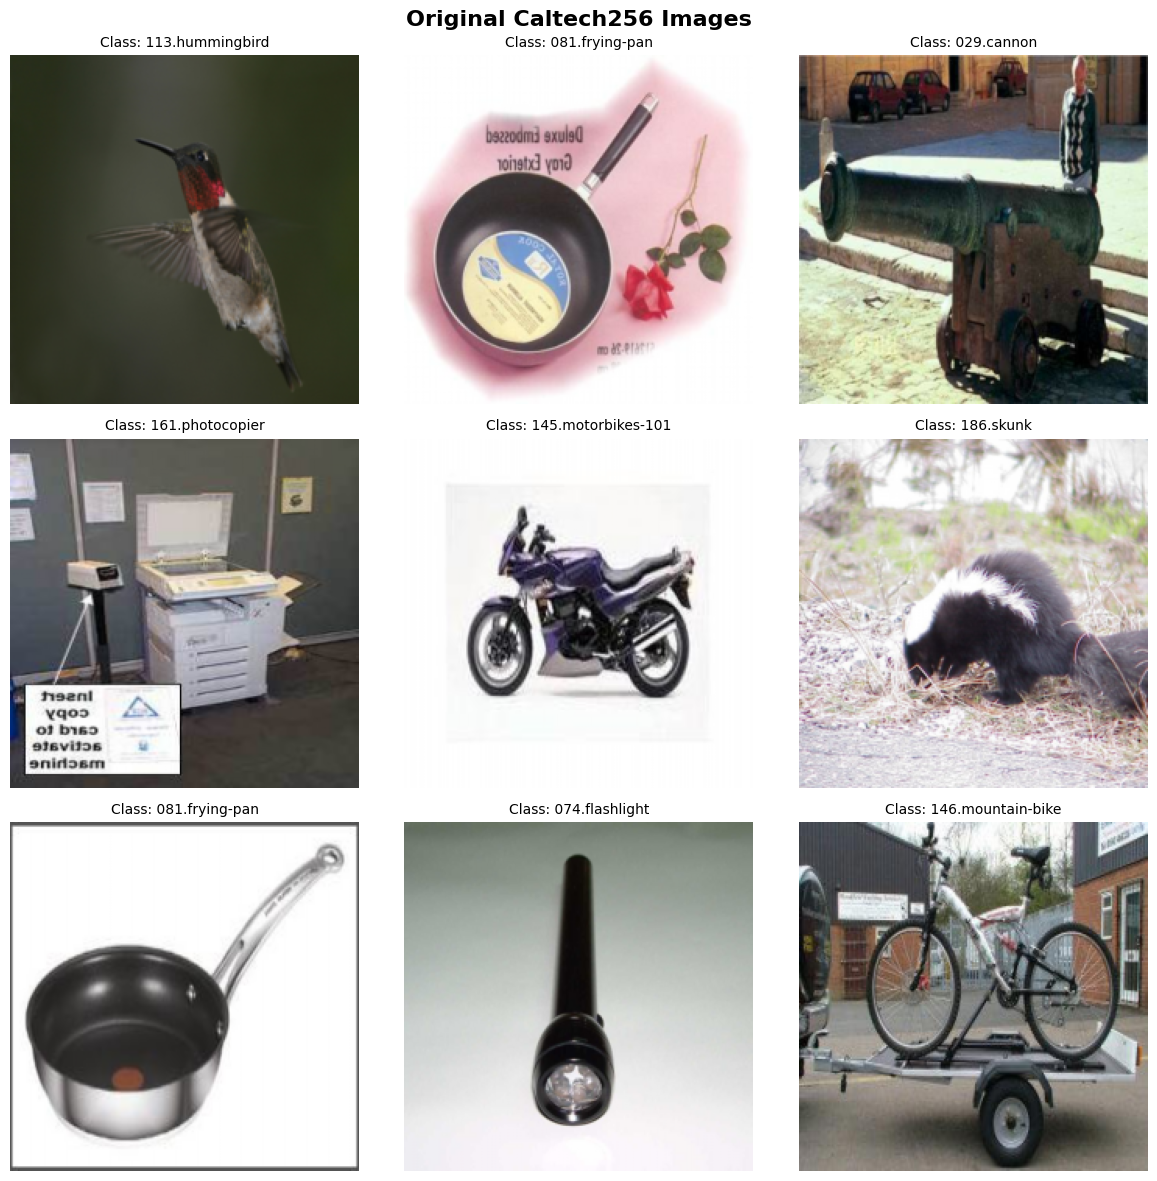

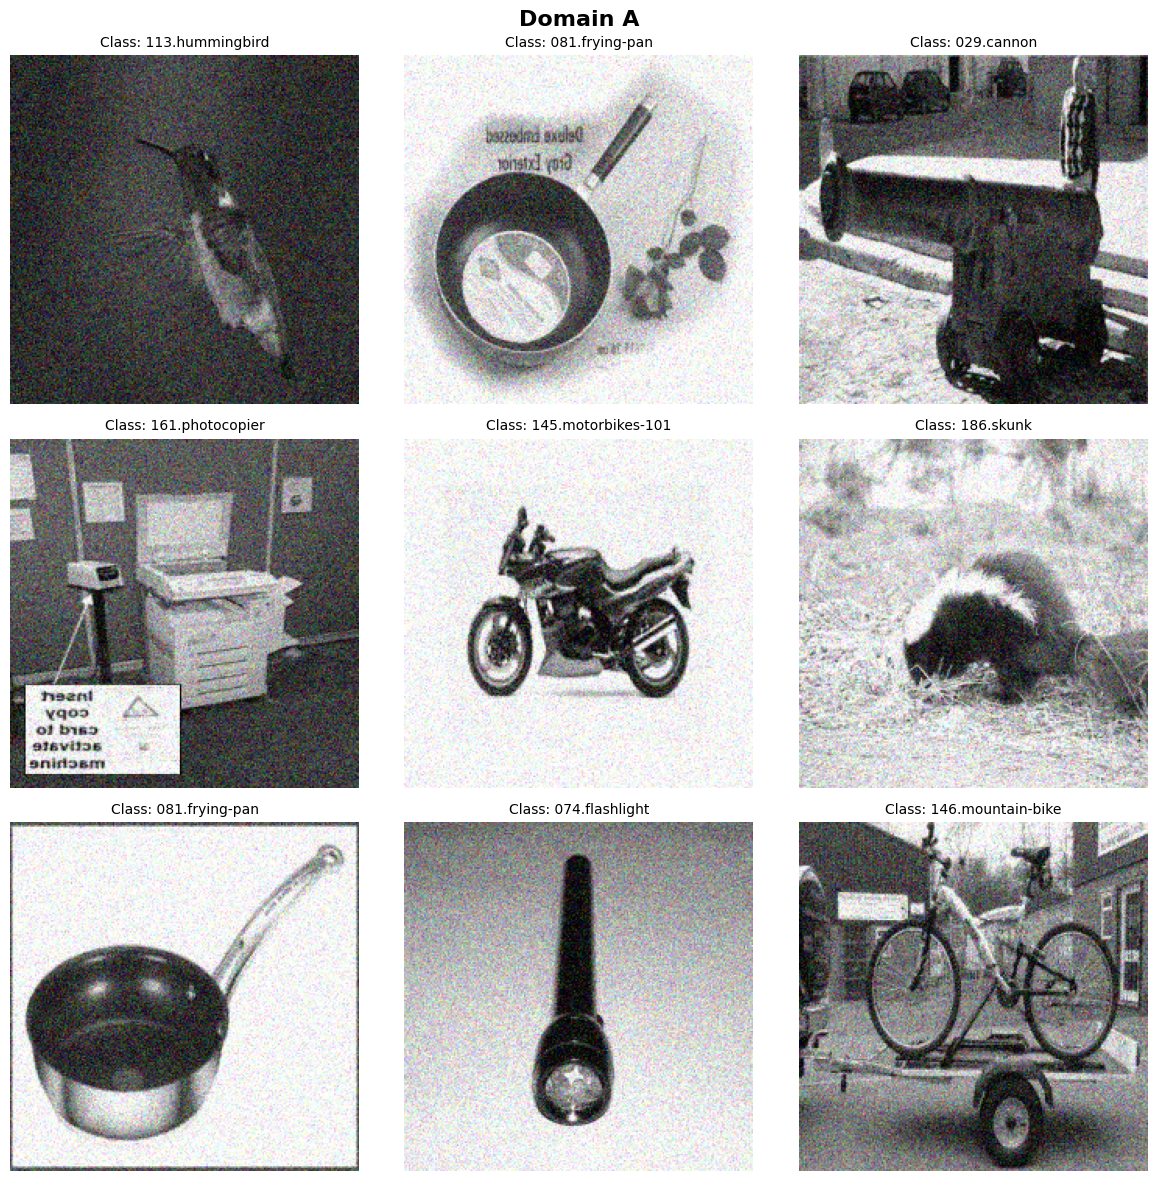

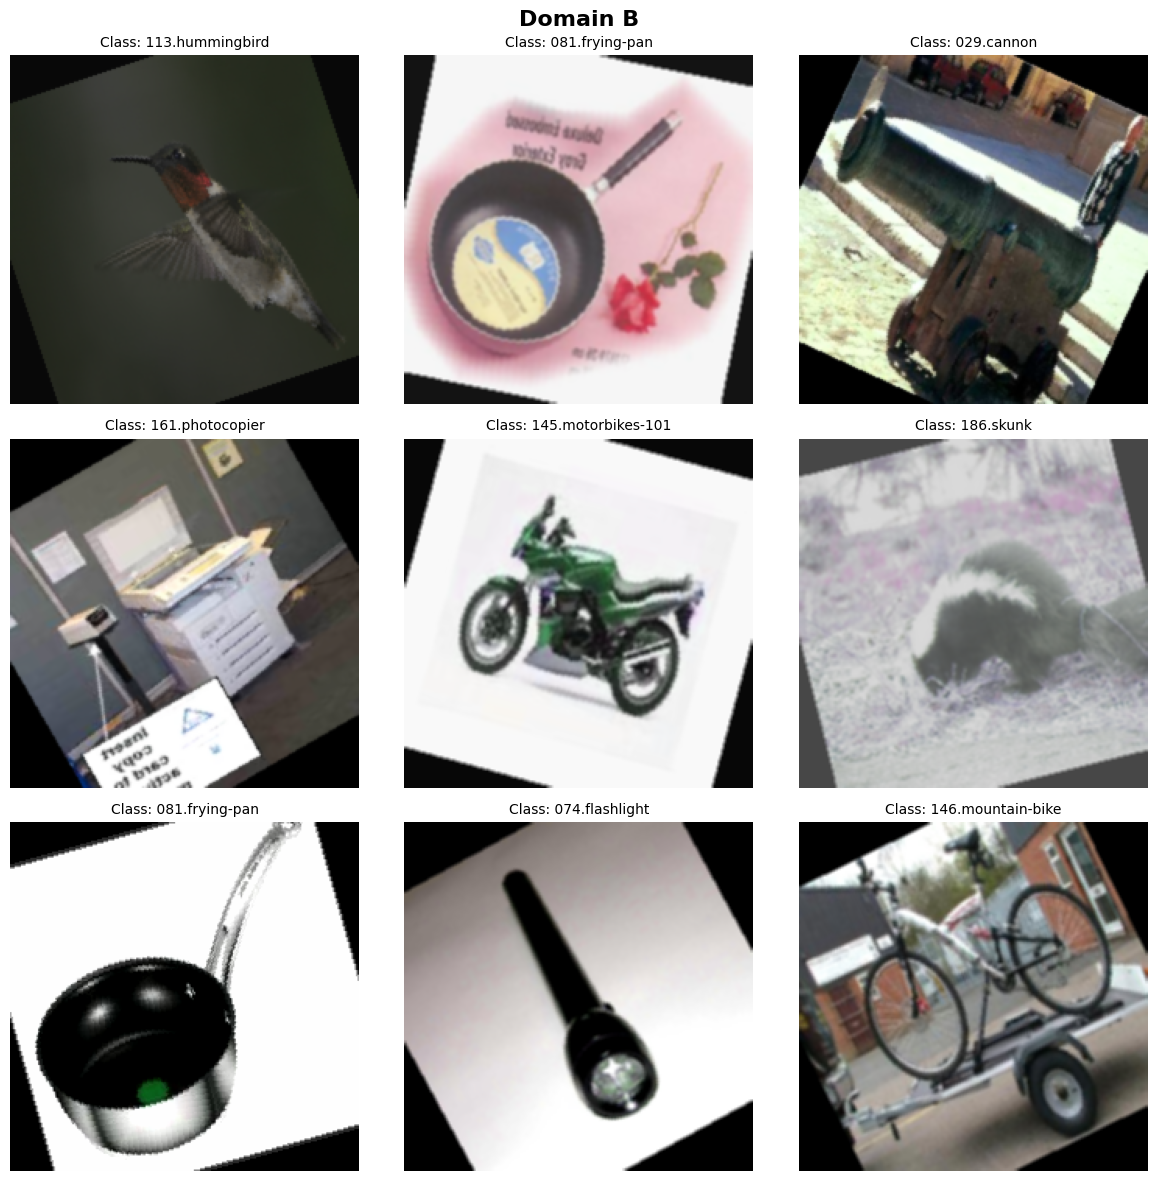

In [3]:
# Create example dataset to visualize domain shifts
from torchvision.datasets import Caltech256
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader

# Load a small subset of Caltech256 for visualization
viz_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.RGB(),
        transforms.Resize(size=(224, 224)),
    ]
)

# Create datasets for visualization
viz_dataset = Caltech256(root="datasets/caltech256", transform=viz_transform)
viz_loader = DataLoader(viz_dataset, batch_size=9, shuffle=True)

# Get one batch of images
images, labels = next(iter(viz_loader))


# Function to apply domain shift and display images
def show_domain_shift_examples(images, domain_shift_transform, title):
    """Display original and domain-shifted images in a 3x3 grid"""
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.suptitle(title, fontsize=16, fontweight="bold")

    # Apply domain shift
    shifted_images = [domain_shift_transform(image) for image in images]

    for i in range(9):
        row = i // 3
        col = i % 3

        # Convert tensor to numpy for display
        img = shifted_images[i].permute(1, 2, 0).numpy()

        # Clip values to [0, 1] range for display
        img = np.clip(img, 0, 1)

        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(f"Class: {caltech256_labels[labels[i]]}", fontsize=10)

    plt.tight_layout()
    plt.show()


# Display original images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Original Caltech256 Images", fontsize=16, fontweight="bold")

for i in range(9):
    row = i // 3
    col = i % 3

    # Convert tensor to numpy for display
    img = images[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    axes[row, col].imshow(img)
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Class: {caltech256_labels[labels[i]]}", fontsize=10)

plt.tight_layout()
plt.show()

# Show Domain A examples
show_domain_shift_examples(images, domain_shift_A, "Domain A")

# Show Domain B examples
show_domain_shift_examples(images, domain_shift_B, "Domain B")

In [4]:
# Create synthetic taxonomy with 2 domains (variant parameters)
synthetic_taxonomy = SyntheticTaxonomy.create_synthetic_taxonomy(
    num_atomic_concepts=257,
    num_domains=2,
    domain_class_count_mean=200,
    domain_class_count_variance=10,
    concept_cluster_size_mean=2,
    concept_cluster_size_variance=1,
    no_prediction_class=True,
    atomic_concept_labels=caltech256_labels,
    relationship_type="true",
)

# Extract domain mappings
domain_A_mapping = synthetic_taxonomy.domains[0].to_mapping()
domain_B_mapping = synthetic_taxonomy.domains[1].to_mapping()

print(f"Domain A classes: {len(set(domain_A_mapping.values()))}")
print(f"Domain B classes: {len(set(domain_B_mapping.values()))}")

Domain A classes: 91
Domain B classes: 93


In [5]:
# Configuration
TRAIN = False  # Set to True to train models from scratch


def train_domain_shifted_model(
    domain_mapping, domain_shift_transform, domain_name, logger_name, model_name
):
    """Train a ResNet model for a specific domain with domain shift"""
    tb_logger = pl_loggers.TensorBoardLogger(save_dir="logs", name=logger_name)
    dataset = Caltech256DomainShiftedDataModule(
        mapping=domain_mapping, domain_shift_transform=domain_shift_transform
    )

    trainer = Trainer(
        max_epochs=50,
        logger=tb_logger if TRAIN else False,
        callbacks=[
            ModelCheckpoint(
                dirpath="checkpoints",
                monitor="val_loss",
                mode="min",
                save_top_k=1,
                filename=model_name,
                enable_version_counter=False,
            )
        ],
    )

    if TRAIN:
        model = ResNetModel(
            num_classes=len(set(domain_mapping.values())),
            architecture="resnet50",
            optim="sgd",
            optim_kwargs={
                "lr": 0.01,
                "momentum": 0.9,
                "weight_decay": 5e-4,
            },
        )
        trainer.fit(model, datamodule=dataset)
        results = trainer.test(datamodule=dataset, ckpt_path="best")
    else:
        try:
            model = ResNetModel.load_from_checkpoint(f"checkpoints/{model_name}.ckpt")
            results = trainer.test(model, datamodule=dataset)
        except FileNotFoundError:
            print(
                f"Checkpoint {model_name}.ckpt not found. Please set TRAIN=True to train the model."
            )
            return None

    print(f"{domain_name} Results: {results}")
    return results

In [6]:
# Train Domain A model
print("Training/Testing Domain A Model:")
domain_A_results = train_domain_shifted_model(
    domain_A_mapping,
    domain_shift_A,
    "Domain A",
    "caltech256_synthetic_variant_domain_shifted_A",
    "resnet50-caltech256-synthetic-variant-domain-shifted-A-min-val-loss",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training/Testing Domain A Model:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bjoern/miniconda3/envs/master-thesis/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 37/37 [00:19<00:00,  1.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      eval_accuracy         0.7014731168746948
        eval_loss           1.3250023126602173
        hp_metric           0.7014731168746948
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Domain A Results: [{'eval_loss': 1.3250023126602173, 'eval_accuracy': 0.7014731168746948, 'hp_metric': 0.7014731168746948}]


In [7]:
# Train Domain B model
print("Training/Testing Domain B Model:")
domain_B_results = train_domain_shifted_model(
    domain_B_mapping,
    domain_shift_B,
    "Domain B",
    "caltech256_synthetic_variant_domain_shifted_B",
    "resnet50-caltech256-synthetic-variant-domain-shifted-B-min-val-loss",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training/Testing Domain B Model:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 37/37 [00:24<00:00,  1.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      eval_accuracy         0.7414675951004028
        eval_loss           1.1764192581176758
        hp_metric           0.7414675951004028
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Domain B Results: [{'eval_loss': 1.1764192581176758, 'eval_accuracy': 0.7414675951004028, 'hp_metric': 0.7414675951004028}]


In [8]:
# Configuration for prediction generation
PREDICT = False  # Set to True to generate predictions from scratch

if PREDICT:
    # Load datasets with domain shifts
    dataset_domain_A = Caltech256DomainShiftedDataModule(
        mapping=domain_A_mapping, domain_shift_transform=domain_shift_A
    )
    dataset_domain_B = Caltech256DomainShiftedDataModule(
        mapping=domain_B_mapping, domain_shift_transform=domain_shift_B
    )

    # Load trained models
    model_domain_A = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-caltech256-synthetic-variant-domain-shifted-A-min-val-loss.ckpt"
    )
    model_domain_A.eval()

    model_domain_B = ResNetModel.load_from_checkpoint(
        "checkpoints/resnet50-caltech256-synthetic-variant-domain-shifted-B-min-val-loss.ckpt"
    )
    model_domain_B.eval()

    trainer = Trainer(logger=False, enable_checkpointing=False)

    # Generate cross-domain predictions
    print("Generating cross-domain predictions...")
    model_A_on_domain_B = trainer.predict(model_domain_A, datamodule=dataset_domain_B)
    model_B_on_domain_A = trainer.predict(model_domain_B, datamodule=dataset_domain_A)

    # Convert predictions to class indices
    predictions_A_on_B = torch.cat(model_A_on_domain_B).argmax(dim=1)  # type: ignore
    predictions_B_on_A = torch.cat(model_B_on_domain_A).argmax(dim=1)  # type: ignore

    # Get ground truth targets
    domain_A_targets = torch.cat(
        [label for _, label in dataset_domain_A.predict_dataloader()]
    )
    domain_B_targets = torch.cat(
        [label for _, label in dataset_domain_B.predict_dataloader()]
    )

    # Save predictions
    pd.DataFrame(
        {
            "domain_A": domain_A_targets,
            "predictions_B_on_A": predictions_B_on_A,
        }
    ).to_csv(
        "data/caltech256_2domain_variant_domain_shifted_A_predictions.csv", index=False
    )

    pd.DataFrame(
        {
            "domain_B": domain_B_targets,
            "predictions_A_on_B": predictions_A_on_B,
        }
    ).to_csv(
        "data/caltech256_2domain_variant_domain_shifted_B_predictions.csv", index=False
    )

    print("Predictions saved to CSV files.")

# Load prediction results
df_A = pd.read_csv("data/caltech256_2domain_variant_domain_shifted_A_predictions.csv")
df_B = pd.read_csv("data/caltech256_2domain_variant_domain_shifted_B_predictions.csv")

print(f"Domain A predictions shape: {df_A.shape}")
print(f"Domain B predictions shape: {df_B.shape}")

Domain A predictions shape: (2308, 2)
Domain B predictions shape: (2344, 2)


In [9]:
taxonomy = CrossPredictionsTaxonomy.from_cross_domain_predictions(
    cross_domain_predictions=[
        (0, 1, np.array(df_B["predictions_A_on_B"], dtype=np.intp)),
        (1, 0, np.array(df_A["predictions_B_on_A"], dtype=np.intp)),
    ],
    domain_targets=[
        (0, np.array(df_A["domain_A"], dtype=np.intp)),
        (1, np.array(df_B["domain_B"], dtype=np.intp)),
    ],
    domain_labels=synthetic_taxonomy.domain_labels,
    relationship_type="mcfp",
)

print("Taxonomy constructed from cross-domain predictions.")

Taxonomy constructed from cross-domain predictions.


In [10]:
print("Generating taxonomy visualizations...")

taxonomy.visualize_graph(
    "2-Domain Caltech256 Variant Domain Shifted Model Taxonomy"
).save_graph(
    "output/caltech256_2domain_variant_domain_shifted_synthetic_model_taxonomy.html"
)

synthetic_taxonomy.visualize_graph(
    "2-Domain Caltech256 Variant Domain Shifted Ground Truth Taxonomy",
    height=2000,
    width=2000,
).save_graph("output/caltech256_2domain_variant_domain_shifted_synthetic_taxonomy.html")

print("Taxonomy visualizations saved to output/ directory.")

Generating taxonomy visualizations...
Taxonomy visualizations saved to output/ directory.


In [11]:
edr = taxonomy.edge_difference_ratio(synthetic_taxonomy)
precision, recall, f1 = taxonomy.precision_recall_f1(synthetic_taxonomy)

print("2-Domain Synthetic Taxonomy Variant Domain Shifted Evaluation:")
print(f"Edge Difference Ratio: {edr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

2-Domain Synthetic Taxonomy Variant Domain Shifted Evaluation:
Edge Difference Ratio: 0.7439
Precision: 0.6630
Recall: 0.3789
F1 Score: 0.4822


In [12]:
print("Building universal taxonomies...")

taxonomy.build_universal_taxonomy()
taxonomy.visualize_graph(
    "2-Domain Caltech256 Variant Domain Shifted Model Universal Taxonomy"
).save_graph(
    "output/caltech256_2domain_variant_domain_shifted_synthetic_model_universal_taxonomy.html"
)

synthetic_taxonomy.build_universal_taxonomy()
synthetic_taxonomy.visualize_graph(
    "2-Domain Caltech256 Variant Domain Shifted Ground Truth Universal Taxonomy"
).save_graph(
    "output/caltech256_2domain_variant_domain_shifted_synthetic_universal_taxonomy.html"
)

print("Universal taxonomy visualizations saved to output/ directory.")

Building universal taxonomies...
Universal taxonomy visualizations saved to output/ directory.


In [13]:
# Create synthetic taxonomy with 2 domains (variant parameters)
synthetic_taxonomy = SyntheticTaxonomy.create_synthetic_taxonomy(
    num_atomic_concepts=257,
    num_domains=2,
    domain_class_count_mean=200,
    domain_class_count_variance=10,
    concept_cluster_size_mean=2,
    concept_cluster_size_variance=1,
    no_prediction_class=True,
    atomic_concept_labels=caltech256_labels,
    relationship_type="true",
)

# Extract domain mappings
domain_A_mapping = synthetic_taxonomy.domains[0].to_mapping()
domain_B_mapping = synthetic_taxonomy.domains[1].to_mapping()

print(f"Domain A classes: {len(set(domain_A_mapping.values()))}")
print(f"Domain B classes: {len(set(domain_B_mapping.values()))}")

Domain A classes: 91
Domain B classes: 93
